<a href="https://colab.research.google.com/github/Corry-Grodek/DataScience/blob/main/Corr_GrodU9Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

import torch
from torch import nn
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#import data from data.gov
crash = pd.read_csv('https://data.austintexas.gov/api/views/y2wy-tgr5/rows.csv?accessType=DOWNLOAD')

<ipython-input-2-3de9b9e88976>:15: DtypeWarning: Columns (6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  crash = pd.read_csv('https://data.austintexas.gov/api/views/y2wy-tgr5/rows.csv?accessType=DOWNLOAD')


# Car Crashes, and colab crashes
I found a cool data set for this project, a list of all of the car crashes in Austin for the past 10 years. These are all of the crashes that first responders responded too, so it does not include small fender benders or things like that. It has a number of data points, including location and units involved, but what interested me most was the "Estimated Maximum Comprehensive Cost." I wanted to see how different factors contributed to this value.

In [3]:
#Clean data
crash.query("crash_speed_limit > 0", inplace=True)
crash.reset_index(drop=True,inplace=True)
crash = crash.rename(columns={'Estimated Total Comprehensive Cost': 'ETCC'})
crash = crash.rename(columns={'Estimated Maximum Comprehensive Cost': 'EMCC'})


In [3]:
#Preview data
pd.set_option('display.max_column', None)
crash.head()

,ID,Crash ID,crash_fatal_fl,case_id,Primary address,Secondary address,rpt_block_num,rpt_street_name,rpt_street_sfx,crash_speed_limit,road_constr_zone_fl,latitude,longitude,crash_sev_id,sus_serious_injry_cnt,nonincap_injry_cnt,poss_injry_cnt,non_injry_cnt,unkn_injry_cnt,tot_injry_cnt,death_cnt,units_involved,point,motor_vehicle_death_count,motor_vehicle_serious_injury_count,bicycle_death_count,bicycle_serious_injury_count,pedestrian_death_count,pedestrian_serious_injury_count,motorcycle_death_count,motorcycle_serious_injury_count,other_death_count,other_serious_injury_count,onsys_fl,private_dr_fl,micromobility_serious_injury_count,micromobility_death_count,Crash timestamp (US/Central),Crash timestamp,Is deleted,Is temporary record,Law enforcement fatality count,Reported street prefix,Estimated Maximum Comprehensive Cost,Estimated Total Comprehensive Cost
0,3819,13721556.0,False,140641657,8600 N US 183 NB HWY,9000 METRIC BLVD,8600,US 183 NB,HWY,65.0,False,30.360368,-97.716673,2,0,1,2,0,0,3,0,Large passenger vehicle & Passenger car,POINT (-97.71667278 30.36036825),0,0,0,0,0,0,0,0,0,0,True,False,0,0,03/05/2014 08:39:00 PM,03/06/2014 02:39:00 AM,False,False,0,NaN,250000,650000
1,1295,13665836.0,False,140080823,2800 N LAMAR BLVD,SAN GABRIEL ST,2800,LAMAR,BLVD,35.0,False,30.244344,-97.781309,3,0,0,4,1,0,4,0,Large passenger vehicle & Passenger car,POINT (-97.78130903 30.24434385),0,0,0,0,0,0,0,0,0,0,True,False,0,0,01/08/2014 01:35:00 PM,01/08/2014 07:35:00 PM,False,False,0,NaN,200000,820000
2,8676,13823911.0,False,141211327,W 44TH ST ST,MEDICAL PKWY PKWY,NaN,W 44TH ST,ST,35.0,False,30.313735,-97.742042,3,0,0,2,0,0,2,0,Passenger car,POINT (-97.74204246 30.31373477),0,0,0,0,0,0,0,0,0,0,False,False,0,0,05/01/2014 05:00:00 PM,05/01/2014 10:00:00 PM,False,False,0,NaN,200000,400000
3,3516,13718478.0,False,140481261,FERGUSON LN LN,DESSAU RD,NaN,FERGUSON LN,LN,40.0,False,NaN,NaN,2,0,1,5,1,0,6,0,Passenger car,NaN,0,0,0,0,0,0,0,0,0,0,False,False,0,0,02/17/2014 05:33:00 PM,02/17/2014 11:33:00 PM,False,False,0,NaN,250000,1270000
4,7154,13794900.0,False,141030937,1810 W SLAUGHTER LN,9800 MANCHACA RD,1810,SLAUGHTER,LN,45.0,False,30.173663,-97.822513,3,0,0,2,0,0,2,0,Passenger car,POINT (-97.82251278 30.17366285),0,0,0,0,0,0,0,0,0,0,False,False,0,0,04/13/2014 03:32:00 PM,04/13/2014 08:32:00 PM,False,False,0,NaN,200000,400000


There is a bunch of factors that could contribute to the cost estimate, so I figured I would graph a few and see what looked interesting.

<Axes: xlabel='crash_speed_limit', ylabel='ETCC'>

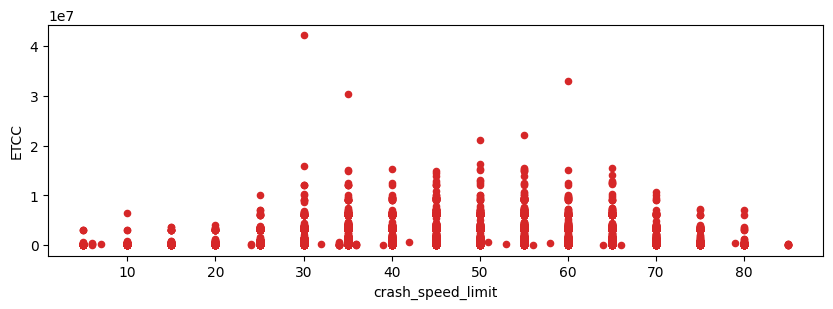

In [21]:
crash.plot(x="crash_speed_limit", y="ETCC", figsize=(10, 3), c='tab:red', kind="scatter")

<Axes: xlabel='poss_injry_cnt', ylabel='ETCC'>

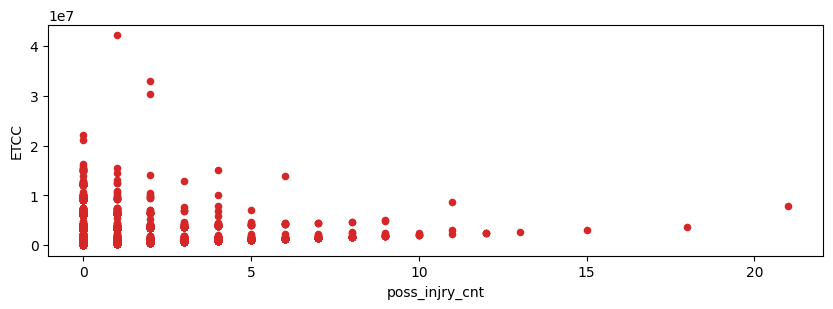

In [20]:
crash.plot(x="poss_injry_cnt", y="ETCC", figsize=(10, 3), c='tab:red', kind="scatter")

<Axes: xlabel='crash_sev_id', ylabel='ETCC'>

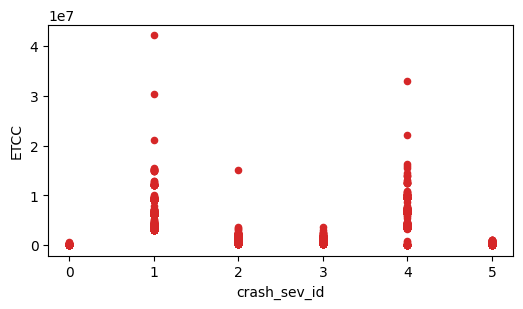

In [19]:
crash.plot(x="crash_sev_id", y="ETCC", c='tab:red',  figsize=(6, 3), kind="scatter")

Of these, speed limit had the most interesting trend and also felt relavent as it was something that could be changed by legislation or policy.

In [7]:
#clean data again
crash = crash[["Estimated Total Comprehensive Cost","crash_speed_limit"]]
crash.dropna()

,Estimated Total Comprehensive Cost,crash_speed_limit
0,650000,65.0
1,820000,35.0
2,400000,35.0
3,1270000,40.0
4,400000,45.0
...,...,...
11859,420000,55.0
11860,640000,55.0
11861,600000,55.0
11862,460000,35.0


I tried going with a multi layer neural network as the trend was not clearly linear. This model is taken straight from the notes.

In [8]:
C = crash["Estimated Total Comprehensive Cost"].to_numpy()
C = C.astype(np.float32)
cost = torch.from_numpy(C)
SL = crash["crash_speed_limit"].to_numpy()
SL = SL.astype(np.float32)
speed = torch.from_numpy(SL)

X = speed.unsqueeze(dim=1) #use height as a predictor
y = cost.unsqueeze(dim=1) #weight is the estimand, the thing we're predicting.

In [77]:
# Scale the height using standardization
scaler = StandardScaler()
speed_scaled = scaler.fit_transform(speed.reshape(-1, 1)  )

cost_scaled = scaler.fit_transform(cost.reshape(-1, 1)  )

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    speed_scaled, cost_scaled, test_size=0.7,
)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [67]:
# Two layer nn with nn.Sequential
model_1 = nn.Sequential(
    #our input is a vector, so 1 diminsion.
    nn.Linear(in_features=1, out_features=32,),
    nn.RReLU(),

    #hidden layer with 32 nodes
    nn.Linear(in_features=32, out_features=16, ),
    nn.RReLU(),

    #moves to hidden layer with 16 nodes
    nn.Linear(in_features=16, out_features=8, ),
    nn.RReLU(),

    #hidden layer with 8 nodes
    nn.Linear(in_features=8, out_features=4, ),
    nn.RReLU(),

    #hidden layer with 4 nodes
    nn.Linear(in_features=4, out_features=1, ),
    #outputs a vector of predicted weights
)

# Create a loss function
loss_fn = nn.MSELoss()

# Create an optimizer; SGD is stochastic gradient decent
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.001) #this is how fast it optimizes; smaller is slower, but more consistent

In [83]:
# Set the number of epochs; this is how many times we update our model
epochs = 2000

for epoch in range(epochs):
    ### Training

    #this allows our matrices to update
    model_1.train()

    # 1. Forward pass; makes predictions
    y_pred = model_1(X_train)

    # 2. Calculate loss; how bad were our predictions?
    loss = loss_fn(y_pred.squeeze(), y_train)

    # 3. Optimizer zero grad; resets how we change our model
    optimizer.zero_grad()

    # 4. Loss backwards; determines how to change our weights matrix
    loss.backward()

    # 5. Optimizer step; changes our weights matrix based on .backward()
    optimizer.step()

    ### Testing
    model_1.eval() #forces our matrices to stay the same
    with torch.inference_mode():
      # 1. Forward pass; makes predictions, but with test data
      test_pred = model_1(X_test)
      # 2. Calculate the loss, but with test data
      test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 200 == 0: #prints every 200 epochs
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([3559, 1])) that is different to the input size (torch.Size([3559])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 | Train loss: 1.02538, Test loss: 0.99922
Epoch: 200 | Train loss: 1.02007, Test loss: 0.99449
Epoch: 400 | Train loss: 1.01845, Test loss: 0.99316
Epoch: 600 | Train loss: 1.01794, Test loss: 0.99281
Epoch: 800 | Train loss: 1.01778, Test loss: 0.99275
Epoch: 1000 | Train loss: 1.01773, Test loss: 0.99274
Epoch: 1200 | Train loss: 1.01771, Test loss: 0.99275
Epoch: 1400 | Train loss: 1.01771, Test loss: 0.99275
Epoch: 1600 | Train loss: 1.01770, Test loss: 0.99275
Epoch: 1800 | Train loss: 1.01770, Test loss: 0.99275


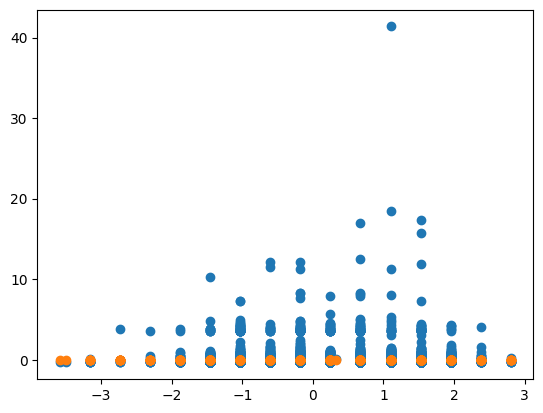

In [85]:
# Turn on evaluation mode
model_1.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_1(X_test)

#plots test data
plt.scatter(X_test.detach().numpy(),y_test.detach().numpy())

#plots predictions--remember, our model has never seen X_test
plt.scatter(X_test.detach().numpy(),y_preds.detach().numpy())

After spending hours fiddling with the model and even trying a different data set I was not able to get the model to work. The train loss and test loss values changed very little, and all of my prediction graphs were way too low. The model would either not decrease any test loss or crash from using too much RAM. I am not sure why this was, but I think the most likely culprit is the format/size of my data.

**Graphs**


Here are some intersting things I was able to graph while I was messing around trying to understand the dataset.

<Axes: xlabel='longitude', ylabel='latitude'>

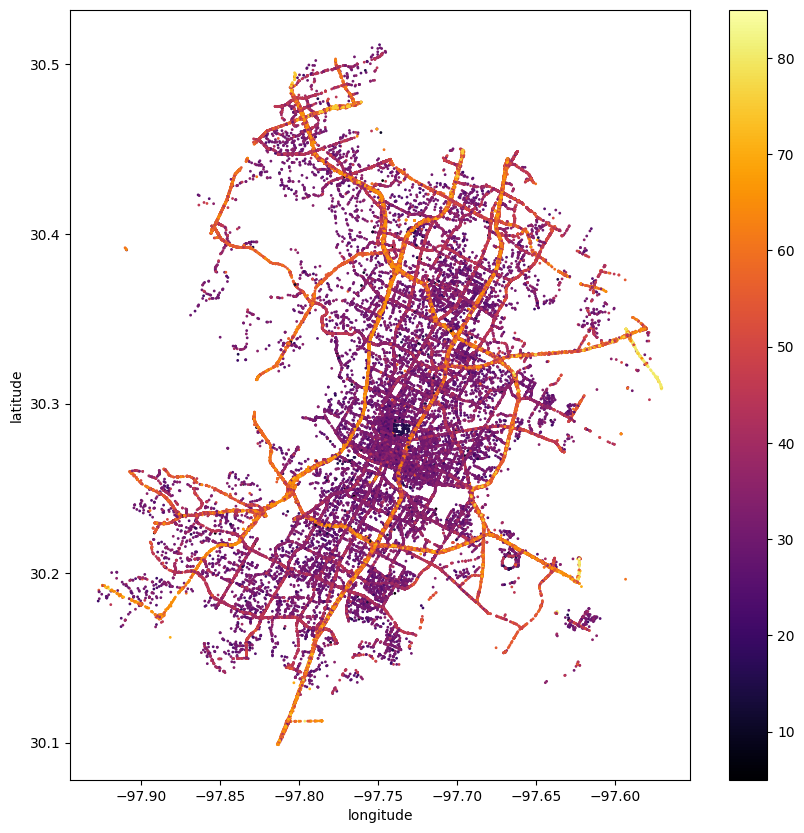

In [61]:
crash.plot(x="longitude", y="latitude", c=crash["crash_speed_limit"],  figsize=(10, 10), kind="scatter", cmap='inferno',  s=1)

This is a map of where crashes occured, and the speed limit where they occured. I thought it was really cool you could see where the highways were and the dark block in the center around what I suspect is UT campus.

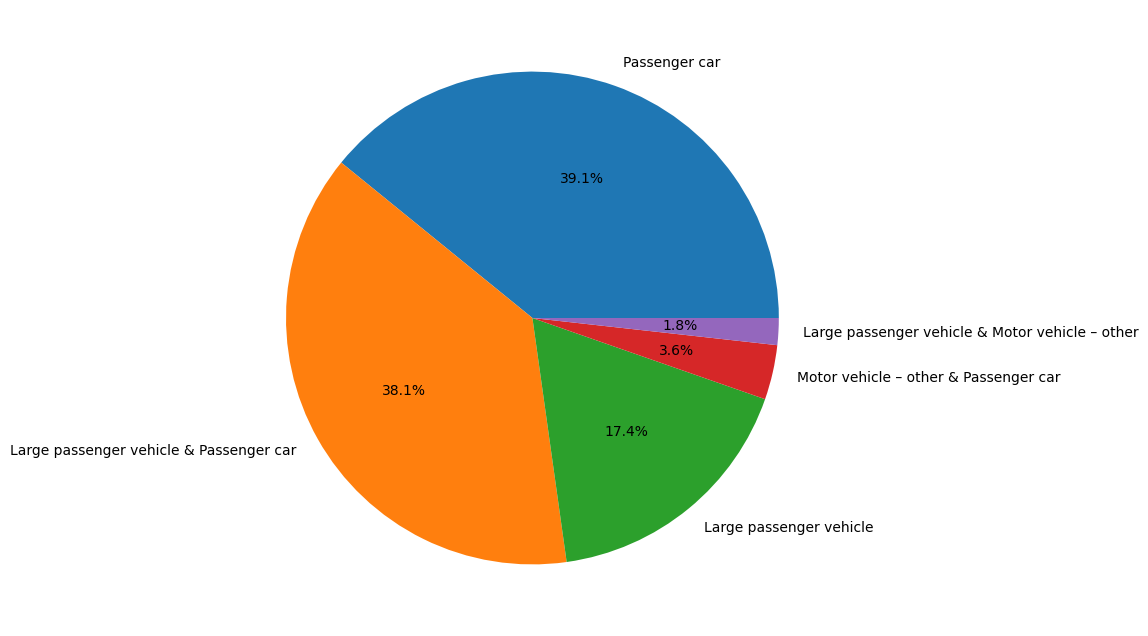

In [86]:
units_counts = crash['units_involved'].value_counts()
top_units = units_counts.nlargest(5)

plt.figure(figsize=(8, 8))
plt.pie(top_units, labels=top_units.index, autopct='%1.1f%%')
plt.show()

This one was created with help from Gemini, and shows the proportion of each type of crash. Large vehicle and passenger car was a much larger portion than I would have thought.

I am disapointed that I was not able to get a neural network working. I think I could have benefitted from trying a much smaller data set, or one with an easier range of data points as  I *think* that is where my problems stemmed from. I think this could definitely be revisited with a simpler model like splines or BART, the speed limit / estimated cost trend looked pretty close to a normal distribution.